# 7-10. 프로젝트 : 단어 Level로 번역기 업그레이드하기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow, os,re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model
from keras import callbacks

In [2]:
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 208906


,eng,fra,cc
158937,I used to play with a couple of boys.,J'avais l'habitude de jouer avec un couple de ...,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
163992,Is there any beer in the refrigerator?,Y a-t-il de la bière au réfrigérateur ?,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
126366,Tom paused to catch his breath.,Tom fit une pause pour reprendre sa respiration.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
7549,I like prunes.,J'aime les pruneaux.,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
66778,I know Tom will be fair.,Je sais que Tom sera équitable.,CC-BY 2.0 (France) Attribution: tatoeba.org #6...


In [3]:
lines = lines[['eng', 'fra']][:33000] # 3만 3천개 샘플 사용
lines.sample(5)

,eng,fra
12404,Tom helps Mary.,Tom aide Marie.
12941,We're up early.,Nous sommes debout tôt.
24451,I checked my bags.,J'ai enregistré mes bagages.
20326,It's a sunny day.,C'est un jour ensoleillé.
31459,I wasn't consulted.,On ne m'a pas consulté.


### Step 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두!) & Step 2. 디코더의 문장에 시작 토큰과 종료 토큰을 넣어주세요.

In [4]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <sos>, 끝에는 <eos>를 추가합니다
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<sos> ' + sentence + ' <eos>' # 6
    return sentence

In [5]:
lines.eng = lines.eng.apply(preprocess_sentence)
lines.fra = lines.fra.apply(preprocess_sentence)

In [6]:
lines.sample(5)

,eng,fra
28498,<sos> who needs a drink ? <eos>,<sos> qui faut il une boisson ? <eos>
15593,<sos> jesus loves you . <eos>,<sos> j sus vous aime . <eos>
17178,<sos> we re different . <eos>,<sos> nous sommes diff rentes . <eos>
4769,<sos> go to school . <eos>,<sos> va l cole . <eos>
1969,<sos> i exercise . <eos>,<sos> je fais de l exercice . <eos>


### Step 3. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.

In [7]:
eng_tokenizer = Tokenizer()   # 문자 단위로 Tokenizer를 생성합니다. 
eng_tokenizer.fit_on_texts(lines.eng)               # 33000개의 행을 가진 eng의 각 행에 토큰화를 수행
input_text = eng_tokenizer.texts_to_sequences(lines.eng)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:3]

[[1, 26, 2], [1, 26, 2], [1, 26, 2]]

In [8]:
fra_tokenizer = Tokenizer()   # 문자 단위로 Tokenizer를 생성합니다. 
fra_tokenizer.fit_on_texts(lines.fra)                 # 33000개의 행을 가진 fra의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(lines.fra)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:3]

[[1, 71, 2], [1, 347, 2], [1, 24, 513, 2]]

In [9]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4618
프랑스어 단어장의 크기 : 7385


In [10]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 9
프랑스어 시퀀스의 최대 길이 16


In [11]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index['eos'] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index['sos'] ] for line in target_text]

In [12]:
print(decoder_input[:3])
print(decoder_target[:3])

[[1, 71], [1, 347], [1, 24, 513]]
[[71, 2], [347, 2], [24, 513, 2]]


In [13]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 9)
프랑스어 입력데이터의 크기(shape) : (33000, 16)
프랑스어 출력데이터의 크기(shape) : (33000, 16)


In [14]:
print(encoder_input[0])

[ 1 26  2  0  0  0  0  0  0]


In [15]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input_train))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input_train))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target_train))

영어 학습데이터의 크기(shape) : (30000, 9)
프랑스어 학습 입력데이터의 크기(shape) : (30000, 16)
프랑스어 학습 출력데이터의 크기(shape) : (30000, 16)


### Step 4. 임베딩 층(Embedding layer) 사용하기 & Step 5. 모델 구현하기

In [16]:
eng_vocab_size = 4618
fra_vocab_size = 7385
output_dim = 512
hidden_state = 256

In [17]:
# 입력 텐서 생성.
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(eng_vocab_size, output_dim)(encoder_inputs)
# hidden size가 256인 인코더의 LSTM 셀 생성
encoder_lstm = LSTM(units = hidden_state, return_state = True)
# 디코더로 전달할 hidden state, cell state를 리턴. encoder_outputs은 여기서는 불필요.
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# hidden state와 cell state를 다음 time step으로 전달하기 위해서 별도 저장.
encoder_states = [state_h, state_c]

In [18]:
# 입력 텐서 생성.
decoder_inputs = Input(shape=(None,))
dec_emb =  Embedding(fra_vocab_size, output_dim)(decoder_inputs)
# hidden size가 256인 인코더의 LSTM 셀 생성
decoder_lstm = LSTM(units = hidden_state, return_sequences = True, return_state=True)
# decoder_outputs는 모든 time step의 hidden state
decoder_outputs, _, _= decoder_lstm(dec_emb, initial_state = encoder_states)

In [19]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [20]:
batch_size = 256
optimizer = tensorflow.keras.optimizers.RMSprop(learning_rate=0.001)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 512)    2364416     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 512)    3781120     input_2[0][0]                    
______________________________________________________________________________________________

In [21]:
check_point = callbacks.ModelCheckpoint('GD-07.keras', save_best_only=True)
early_stopping = callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

history = model.fit(
    
    x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
    validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
    batch_size=batch_size,
    epochs=100,
    callbacks=[check_point, early_stopping]
)

Epoch 1/100
118/118 [==============================] - 10s 48ms/step - loss: 2.0144 - accuracy: 0.7170 - val_loss: 1.9427 - val_accuracy: 0.7071
Epoch 2/100
118/118 [==============================] - 5s 43ms/step - loss: 1.4546 - accuracy: 0.7687 - val_loss: 1.7792 - val_accuracy: 0.7215
Epoch 3/100
118/118 [==============================] - 5s 43ms/step - loss: 1.2783 - accuracy: 0.7931 - val_loss: 1.6192 - val_accuracy: 0.7494
Epoch 4/100
118/118 [==============================] - 5s 43ms/step - loss: 1.1365 - accuracy: 0.8108 - val_loss: 1.5259 - val_accuracy: 0.7599
Epoch 5/100
118/118 [==============================] - 5s 43ms/step - loss: 1.0248 - accuracy: 0.8245 - val_loss: 1.4260 - val_accuracy: 0.7734
Epoch 6/100
118/118 [==============================] - 5s 43ms/step - loss: 0.9326 - accuracy: 0.8366 - val_loss: 1.3644 - val_accuracy: 0.7791
Epoch 7/100
118/118 [==============================] - 5s 43ms/step - loss: 0.8559 - accuracy: 0.8459 - val_loss: 1.2999 - val_accuracy

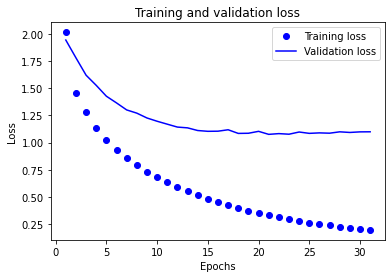

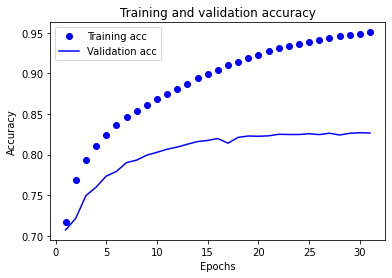

In [22]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Step 6. 모델 평가하기

In [23]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 512)         2364416   
_________________________________________________________________
lstm (LSTM)                  [(None, 256), (None, 256) 787456    
Total params: 3,151,872
Trainable params: 3,151,872
Non-trainable params: 0
_________________________________________________________________


In [24]:
# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_state,))
# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(hidden_state,))
# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# decoder_states_inputs를 현재 time step의 초기 상태로 사용.
# 구체적인 동작 자체는 def decode_sequence()에 구현.
decoder_outputs, state_h, state_c = decoder_lstm(dec_emb, initial_state = decoder_states_inputs)
# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장.
decoder_states = [state_h, state_c]

In [25]:
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 512)    3781120     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
____________________________________________________________________________________________

In [26]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [27]:
eng2idx['unk'] = 0
fra2idx['unk'] = 0
idx2eng[0] = 'unk'
idx2fra[0] = 'unk'

In [28]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = fra2idx['sos']

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        
        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' ' + sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if sampled_char == 'eos':
            stop_condition = True
            decoded_sentence = decoded_sentence[:-3] ### <eos>에 도달하면 <eos>를 지우고 출력
        if len(decoded_sentence.split()) > max_fra_seq_len:
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [29]:
for i in range(10): # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    random_index = np.random.randint(0, 32999)
    input_seq = encoder_input[random_index: random_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[random_index][6:-6])# 'sos'와 'eos'을 빼고 출력
    print('정답 문장:', lines.fra[random_index][6:-6]) # 'sos'와 'eos'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence)

-----------------------------------
입력 문장: tom hurt his knee .
정답 문장: tom s est fait mal au genou .
번역기가 번역한 문장:  tom s est fait au courant 
-----------------------------------
입력 문장: tom warned mary .
정답 문장: thomas avertit marie .
번역기가 번역한 문장:  tom a regard marie 
-----------------------------------
입력 문장: they ll call .
정답 문장: ils vont t l phoner .
번역기가 번역한 문장:  ils vont un coup de retour 
-----------------------------------
입력 문장: tom is a cancer .
정답 문장: tom est cancer .
번역기가 번역한 문장:  tom est un cancer 
-----------------------------------
입력 문장: i broke my glasses .
정답 문장: j ai cass mes lunettes .
번역기가 번역한 문장:  je me suis cass e 
-----------------------------------
입력 문장: do you like music ?
정답 문장: la musique vous pla t ?
번역기가 번역한 문장:  est ce que tu aimes la musique 
-----------------------------------
입력 문장: this is urgent .
정답 문장: c est urgent .
번역기가 번역한 문장:  c est incroyable 
-----------------------------------
입력 문장: i m not ugly .
정답 문장: je ne suis pas laid .
번역기가 번역한 문장:  je 

1. 입력 문장: 톰은 무릎을 다쳤다.  
    정답 문장: tom s est fait mal au genou .  
    번역기가 번역한 문장:  tom s est fait au courant - 톰은 알게 되었다. __(X)__
------------------------------------------------------ 
2. 입력 문장: 톰은 메리에게 경고했다.  
    정답 문장: thomas avertit marie .  
    번역기가 번역한 문장:  tom a regard marie - 톰은 마리를 쳐다보았다. __(X)__
-----------------------------------
3. 입력 문장: 그 사람들이 전화할 겁니다.  
    정답 문장: ils vont t l phoner .  
    번역기가 번역한 문장:  ils vont un coup de retour - 그들은 원샷 뒤로 간다 __(X)__
-----------------------------------
4. 입력 문장: 톰은 게자리다.  
    정답 문장: tom est cancer .  
    번역기가 번역한 문장:  tom est un cancer - 톰은 게자리다. __(O)__
-----------------------------------
5. 입력 문장: 나는 안경을 부러뜨렸다.  
    정답 문장: j ai cass mes lunettes .  
    번역기가 번역한 문장:  je me suis cass e - 나는 무너졌다 __(X)__
-----------------------------------
6. 입력 문장: do you like music ?    
    정답 문장: la musique vous pla t ?  
    번역기가 번역한 문장:  est ce que tu aimes la musique - 음악을 좋아해요? __(O)__
-----------------------------------
7. 입력 문장: 급한 일이야.  
    정답 문장: c est urgent .  
    번역기가 번역한 문장:  c est incroyable - 믿을 수 없어. __(X)__
-----------------------------------
8. 입력 문장: 난 못생기지 않았어.  
    정답 문장: je ne suis pas laid .  
    번역기가 번역한 문장:  je ne suis pas laid __(O)__
-----------------------------------
9. 입력 문장: 가고 싶어?  
    정답 문장: veux tu partir ?  
    번역기가 번역한 문장:  veux tu y aller - 거기에 가고 싶니? __(O)__
-----------------------------------
10. 입력 문장: i m a free man .    
    정답 문장: je suis un homme libre .  
    번역기가 번역한 문장:  je suis un homme libre __(O)__

##### 절반은 맞췄다.

### 회고

##### 어려웠던 점, 해결을 위해 시도한 방법, 문제해결에 성공한 이유 또는 실패한 이유
	: embedding layer를 만드는 과정에서 노드의 hidden_state였던 256을 사용할 지 다른 값을 사용할 지 고민이 돼서 chat GPT한테 물어봤는데 128을 보통 많이 하고 여기서 조정해나가면 된다고 했다. 그래서 256으로 좋은 결과가 나오지 않으면 hidden_state를 128로 하려고 했다. 하지만 단어장이 커져서 hidden state를 더 키우기로 했다.
    decode_sequence 함수를 만드는 과정이 어려웠다. input과 output의 shape을 맞춰줘야 하는데 input shape이 1인 이유를 모르겠었다.
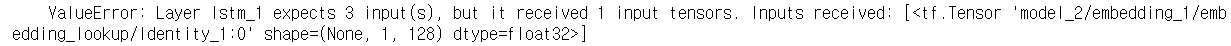

    그래서 encoder_input.shape을 확인했는데 2차원이었다. 노드에서는 3차원이었어서 shape 에러가 날 수 있다고 했다. 그런데 shape이 문제가 아닌 것 같아서, def 안에서 print를 해가면서 확인했는데, sampled_token_index가 0일 때 에러가 나는 것이 문제였다. 왜냐면 0은 패딩인데, 단어장에 패딩이 없었기 때문이다. 내가 pre로 패딩을 채워서 많은 문장들이 0으로 시작했을텐데, 그걸 unk로 지정해주지 않아서 계속 못알아낸 것이었다. 우선 단어장에 0을 만들어줬고, 그리고 실행했는데
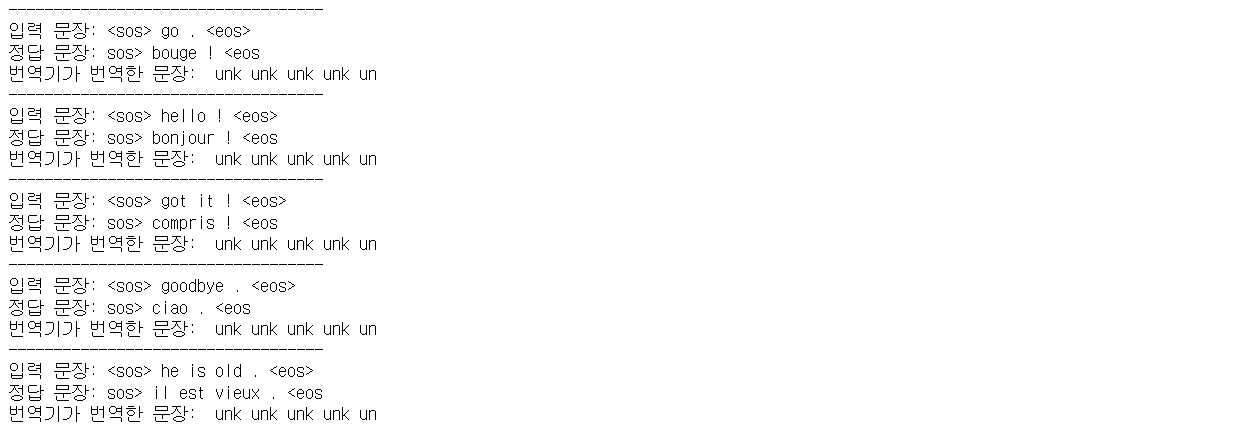

    unk만 내보내는 모델이 되어버렸다. padding을 post로 변경하고 다시 실행하니까 제대로 번역된 결과물이 나왔다.
    
    decode sequence 내부에서
    
            # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if sampled_char == 'eos':
            stop_condition = True
            decoded_sentence = decoded_sentence[:-3]
        if len(decoded_sentence.split()) > max_fra_seq_len:
            stop_condition = True
            
    이 부분을 코드를 짜면서 고려해줘야 했다. decoded_sentence를 split하지 않으면 max_fra_seq_len이 16이기 때문에 글자수가 16이 넘어가버리면 아예 잘려버렸다. 단어를 기준으로 해야했기 때문에 split을 꼭 해줘야 했고, eos에 도달하면 그 뒤에 슬라이싱으로 무조건 [:3] 해버렸을 때 eos에 도달해서 끝난 게 아니라 그저 길이가 길어서 끝난 경우도 있기 때문에 함수 내부에서 고쳐줘야 했다.
    
##### 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
	: padding을 post로 해야하는 이유는?
    첫번째 정보가 그 뒤의 문장에 대해 영향을 주기 때문에, 처음에 0으로 시작하게 된다면 그 뒤에 0이 대부분이 찍혀있기 때문에 계속해서 0을 예측할 수 있다. 그러므로 이 경우에는 post 패딩을 넣는 것이 좋다.

##### 루브릭 평가 지표를 맞추기 위해 시도한 내용
	: 이전 노드를 보면서 전처리를 했고 apply 메소드의 사용법을 복습했다. 그래프를 그렸고 earlystopping으로 과대적합 되기 전 모델을 저장했다. 한국어로 번역해보았다.

##### 자기 다짐, 프로젝트를 진행하면서 느낀점
	: accuracy에 대한 루브릭이 없으니 내가 이 모델이 잘 하고 있는지 아닌 지 판단할 권한이 생겼다고 느꼈다. 직접 번역을 시켜보니 프랑스어의 특성상 구두점인 "'"이 많이 등장해서 번역이 더 어려웠지 않았나 싶다. 좀 더 맥락을 이해하는 번역기에 대해 공부해보고 싶다. 나는 번역기를 정말 잘 만들고 싶다. 특히 웹툰을 맥락에 따라 잘 번역해주면 좋겠다. 최근에도 외국인 친구가 '다 간 것 같은데?'라는 대사를 혼자서 번역해봤다면서 'Everything (that we've done) it's completely looks like a gap.' 이라고 번역했다면서 맞냐고 물어봤는데, '간'을 동사와 형태소의 결합이라고 보지 못하고 신체 장기인 간의 뜻을 보고 맥락에 맞지 않다고 생각했는지 이건 번역하는 단어에 사용하지 않고 넘겼지만, 사이를 뜻하는 간 등으로 번역하고 '다'를 지칭하는 대상이 사람이 될 수는 없다고 생각해서 이렇게 번역을 해버린 것 같았다. 한국어는 형태소와의 결합에 따라서 정말 다양한 뜻이 되는데, 주어도 없는 편이라서 맥락이 정말 중요한 편이다. 웹툰에는 그런 대사들이 정말 많은데 이걸로 한국어를 공부하는 친구를 너무 도와주고 싶다. 매번 내가 이렇게 하나하나 알려주기 보다는 딥러닝 모델을 제대로 된 걸 만들어주고 싶다.
    통계적 기계번역을 적용하고난 뒤에 언어인식기의 성능이 올라갔다고 했다. 웹툰의 장르별 언어인식기를 만들게 되면 더 성능이 올라가지 않을까? 로맨스 장르에 자주 등장하는 단어들, 맥락들이 있고 무협지 장르에 자주 등장하는 것들이 정해져있다. 먼저 제일 제대로됐을 가능성이 높은 번역 문장을 하나 보여주고, 그 뒤에 그 다음 가능성이 있을 문장을 보여줘서 선택하게 하면 아예 딴소리하는 번역은 없어질 것 같다. 정말 꼭 언젠가 만들 수 있으면 좋겠다.